In [1]:
%matplotlib inline

In [2]:
# !pip install -U tensorflow

In [73]:
import pandas as pd
import numpy as np
import pycaret
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing 

# Load data
We start by loading only the transactions involved, to be able to select these for model training

In [4]:
trx = pd.read_csv('transactions.csv')
original_trx_data = trx.copy()
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197905 entries, 0 to 197904
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tran_id         197905 non-null  int64  
 1   orig_acct       197905 non-null  int64  
 2   bene_acct       197905 non-null  int64  
 3   tx_type         197905 non-null  object 
 4   base_amt        197905 non-null  float64
 5   tran_timestamp  197905 non-null  object 
 6   is_sar          197905 non-null  bool   
 7   alert_id        197905 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 10.8+ MB


In [5]:
trx.describe()

,tran_id,orig_acct,bene_acct,base_amt,alert_id
count,197905.000000,197905.000000,197905.000000,197905.000000,197905.000000
mean,98953.000000,1909.848776,569.676481,546.631910,-0.823547
std,57130.396849,1618.013120,1695.983714,261.671165,3.472225
min,1.000000,0.000000,0.000000,0.090000,-1.000000
25%,49477.000000,461.000000,24.000000,319.580000,-1.000000
50%,98953.000000,2098.000000,53.000000,546.780000,-1.000000
75%,148429.000000,2738.000000,191.000000,772.290000,-1.000000
max,197905.000000,12007.000000,11991.000000,999.990000,99.000000


In [6]:
#Check if the data has an NaN values
trx.isnull().any()

tran_id           False
orig_acct         False
bene_acct         False
tx_type           False
base_amt          False
tran_timestamp    False
is_sar            False
alert_id          False
dtype: bool

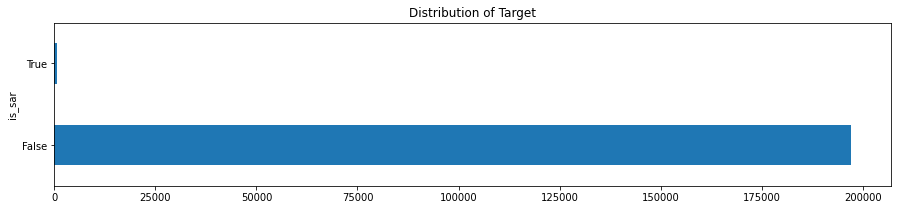

In [7]:
trx['is_sar'].value_counts()
trx.groupby('is_sar') \
    .count()['tran_id'] \
    .plot(kind='barh',
          title='Distribution of Target',
          figsize=(15, 3))
plt.show()

### Initial Assumption
Clearly the data is totally unbalanced!!
This is a clear example where we cannot use accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!
There are several ways to approach this classification problem taking into consideration this imbalance.
1. Collect more data? Nice strategy but not applicable in this case. However we can use the larger dataset but it will still be imbalanced
2. Changing the performance metric:
   - Use the confusion matrix to calculate Precision, Recall
   - F1score (weighted average of precision recall)
   - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
   - ROC curves - calculates sensitivity/specificity ratio.




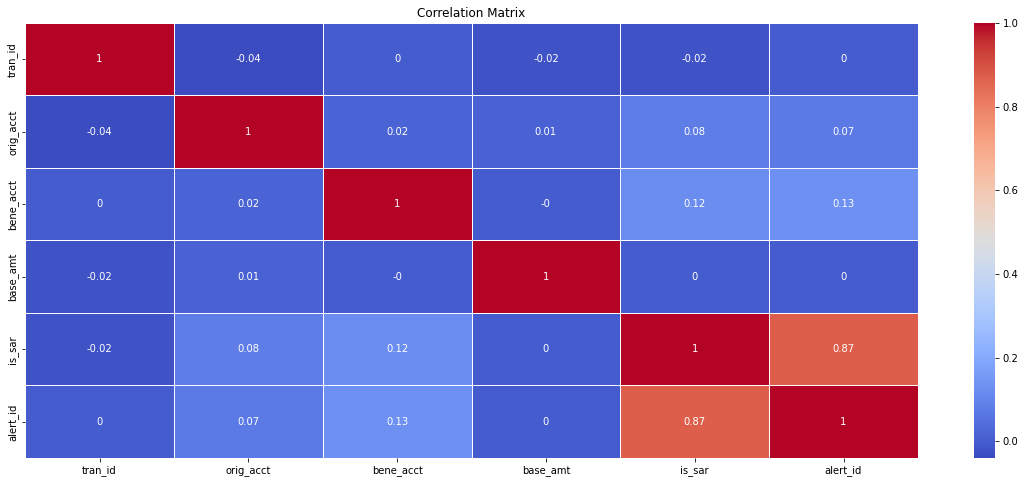

In [8]:
#Lets also check if there is correlation between different features
corr = trx.corr()
 
plt.figure(figsize=(20,8))
fig = sns.heatmap(corr.round(2), cmap='coolwarm', linewidths=.5, annot=True)
fig.set(title="Correlation Matrix");

We can see that `alert_id` is highly correlated to `is_sar`

### TransactionAmt(base_amt)
The amount of transaction. I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.

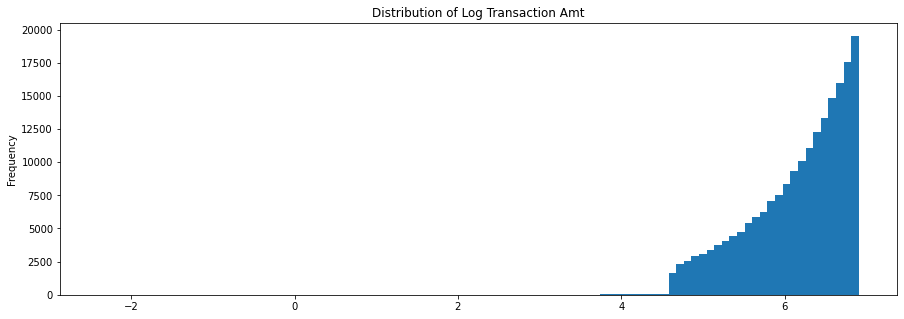

In [9]:
trx['base_amt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

In [10]:
#Checking the transaction amount per SAR
amt_per_sar= trx.groupby('is_sar')['base_amt'].agg([max, min])
amt_per_sar

,max,min
is_sar,,
False,999.99,0.09
True,999.17,8.77


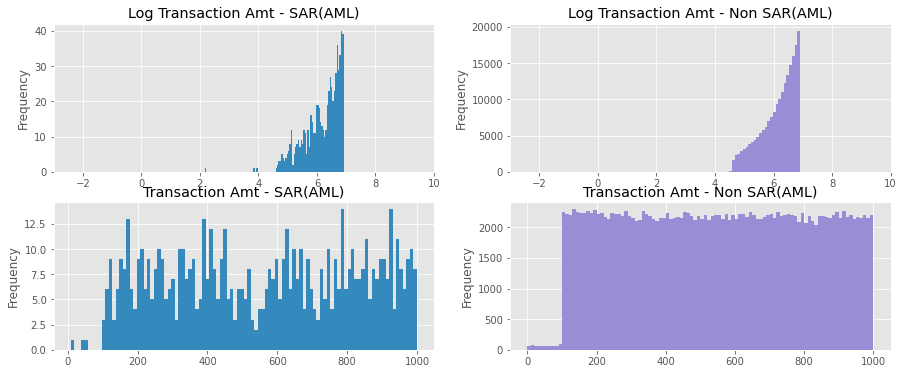

In [11]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
trx.loc[trx['is_sar'] == True] \
    ['base_amt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - SAR(AML)',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
trx.loc[trx['is_sar'] == False] \
    ['base_amt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Non SAR(AML)',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
trx.loc[trx['is_sar'] == True] \
    ['base_amt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - SAR(AML)',
          color=color_pal[1],
         ax= ax3)
trx.loc[trx['is_sar'] == False] \
    ['base_amt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Non SAR(AML)',
          color=color_pal[2],
         ax=ax4)
plt.show()

NON SAR AML transactions appear to have a higher average transaction amount

In [12]:
print('Mean transaction amt for fraud is {:.4f}'.format(trx.loc[trx['is_sar'] == True]['base_amt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(trx.loc[trx['is_sar'] == False]['base_amt'].mean()))

Mean transaction amt for fraud is 558.0868
Mean transaction amt for non-fraud is 546.5929


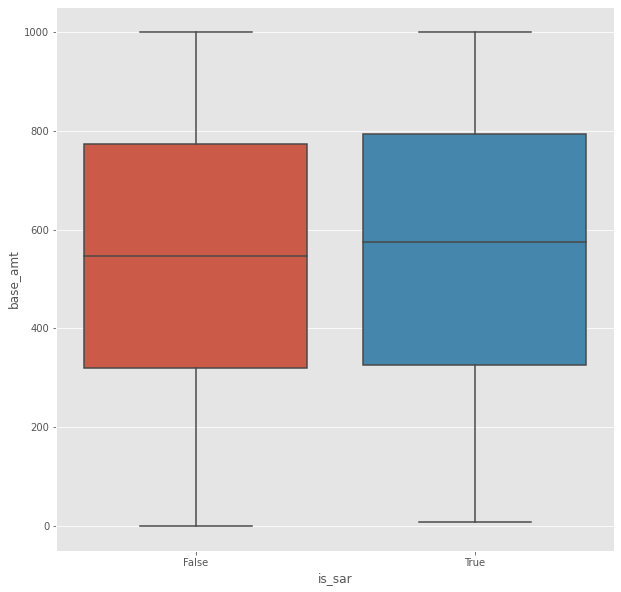

In [13]:
fig, axs = plt.subplots(figsize=(10, 10))
a = sns.boxplot(x = 'is_sar', y = 'base_amt', data = trx)

In [14]:
trx['tran_timestamp'] = pd.to_datetime(trx['tran_timestamp'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

In [15]:
trx['ScheduledDay_year'] = trx['tran_timestamp'].dt.year
trx['ScheduledDay_month'] = trx['tran_timestamp'].dt.month
trx['ScheduledDay_week'] = trx['tran_timestamp'].dt.week
trx['ScheduledDay_day'] = trx['tran_timestamp'].dt.day
trx['ScheduledDay_hour'] = trx['tran_timestamp'].dt.hour
trx['ScheduledDay_minute'] = trx['tran_timestamp'].dt.minute
trx['ScheduledDay_dayofweek'] = trx['tran_timestamp'].dt.dayofweek

/tmp/ipykernel_1926/2861054840.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  trx['ScheduledDay_week'] = trx['tran_timestamp'].dt.week


In [16]:
trx.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id,ScheduledDay_year,ScheduledDay_month,ScheduledDay_week,ScheduledDay_day,ScheduledDay_hour,ScheduledDay_minute,ScheduledDay_dayofweek
0,1,4376,170,TRANSFER,885.30,2017-01-01,False,-1,2017,1,52,1,0,0,6
1,2,4300,23,TRANSFER,630.41,2017-01-01,False,-1,2017,1,52,1,0,0,6
2,3,4433,12,TRANSFER,393.14,2017-01-01,False,-1,2017,1,52,1,0,0,6
3,4,2552,6503,TRANSFER,659.74,2017-01-01,False,-1,2017,1,52,1,0,0,6
4,5,2552,6503,TRANSFER,442.44,2017-01-01,False,-1,2017,1,52,1,0,0,6


In [17]:
def calc_prevalence(y):
    return (sum(y)/len(y))

In [18]:
trx.groupby('ScheduledDay_dayofweek').apply(lambda x: calc_prevalence(x.is_sar.values))

ScheduledDay_dayofweek
0    0.003964
1    0.003117
2    0.003454
3    0.003037
4    0.003530
5    0.002759
6    0.003894
dtype: float64

A strange observation is that the transactions are happening every alternate day of the week.

In [19]:
#Let's check the distribution of amount for the transactions
amount_val = trx['base_amt'].values


Text(0.5, 1.0, 'Distribution of Transaction Amount')

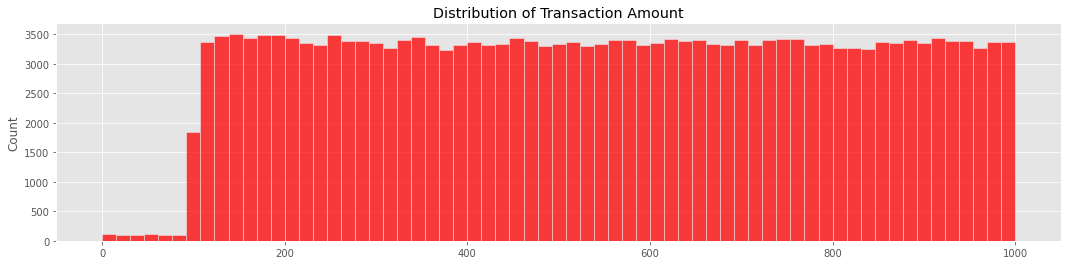

In [20]:
fig= plt.subplots(figsize=(18,4))
sns.histplot(amount_val,  color='r').set_title('Distribution of Transaction Amount')

<function matplotlib.pyplot.show(close=None, block=None)>

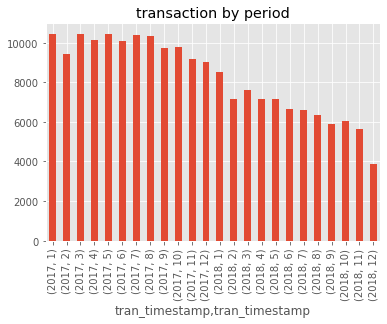

In [21]:
#check over which period
trx.groupby([trx["tran_timestamp"].dt.year, trx["tran_timestamp"].dt.month])['tran_id'].count().plot(kind="bar")
plt.title('transaction by period')
plt.show

### Observation from transaction file

1. We can also see that the transactions were higher in the Jan 2017 ann they have gradually descreased over the period of time.
2. One important thing to notice is regarding the amount of transaction done when SAR==True, We can notice that the amount is very inconsistent with peaks near to 200, 400, 600, 800 and 1000 dollars and they also have a minimum transaction value(`$8.77`). However the false alerts are always maxed out and mostly above `1000$` with no minimum value.

What would be a warning sign for fraud or money laundering activities?

1. One such thing can be irregularly large transaction volume from an account is a red flag. Also, this exploitation could also be over a period of time, since the perpetrators don’t want to alert the bank with a single large transaction.

Let’s see how these AML alerts are raised using the `alerts_transaction` file

In [22]:
alert_tx = pd.read_csv('alert_transactions.csv')

In [24]:
alert_tx.head()

,alert_id,alert_type,is_sar,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp
0,28,fan_in,True,39,6568,362,TRANSFER,370.25,2017-01-01T00:00:00Z
1,25,fan_in,True,77,6035,726,TRANSFER,969.03,2017-01-01T00:00:00Z
2,12,fan_in,True,80,1002,546,TRANSFER,359.95,2017-01-01T00:00:00Z
3,23,fan_in,True,85,7518,686,TRANSFER,842.13,2017-01-01T00:00:00Z
4,29,fan_in,True,103,6666,448,TRANSFER,943.53,2017-01-01T00:00:00Z


In [25]:
#Checking the unique alert
total_unique_alerts = len(alert_tx['alert_id'].unique())
print(f'Total unique alerts: {total_unique_alerts}')
sar_unique_alerts = len(alert_tx.loc[alert_tx['is_sar']==True]['alert_id'].unique())
print(f'Out of Total Unique alerts {total_unique_alerts}, SAR unique alerts: {sar_unique_alerts}')

Total unique alerts: 100
Out of Total Unique alerts 100, SAR unique alerts: 100


In [26]:
#Checking the unique alert
total_unique_alerts = len(alert_tx['alert_type'].unique())
print(f'Total unique alerts: {total_unique_alerts}')
sar_unique_alerts = len(alert_tx.loc[alert_tx['is_sar']==True]['alert_type'].unique())
print(f'Out of Total Unique alerts {total_unique_alerts}, SAR unique alerts: {sar_unique_alerts}')

Total unique alerts: 3
Out of Total Unique alerts 3, SAR unique alerts: 3


In [27]:
#Checking the unique transaction type
total_unique_transaction = len(alert_tx['tx_type'].unique())
total_unique_transaction

1

In [28]:
#Checking the transaction amount per SAR
amt_per_sar= alert_tx.groupby('is_sar')['base_amt'].agg([max, min])
amt_per_sar

,max,min
is_sar,,
True,999.17,8.77


Text(0.5, 1.0, 'Distribution of Transaction Amount')

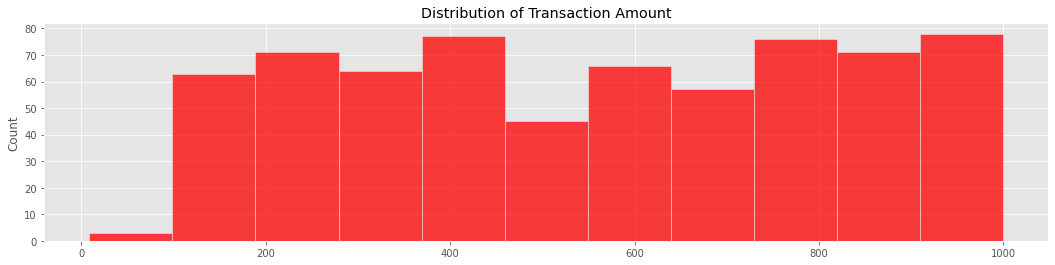

In [29]:
#Let's check the distribution of amount for the transactions
amount_val = alert_tx['base_amt'].values
fig= plt.subplots(figsize=(18,4))
sns.histplot(amount_val,  color='r').set_title('Distribution of Transaction Amount')

In [30]:
alert_tx['tran_timestamp'] = pd.to_datetime(alert_tx['tran_timestamp'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

<function matplotlib.pyplot.show(close=None, block=None)>

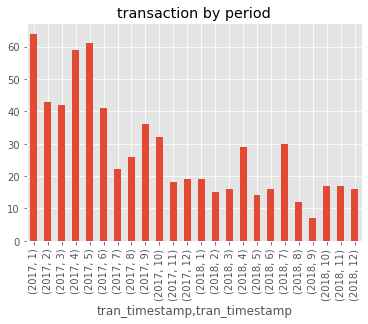

In [31]:
#check over which period
alert_tx.groupby([alert_tx["tran_timestamp"].dt.year, alert_tx["tran_timestamp"].dt.month])['tran_id'].count().plot(kind="bar")
plt.title('transaction by period')
plt.show

is_sar
True    AxesSubplot(0.125,0.125;0.775x0.755)
Name: days, dtype: object

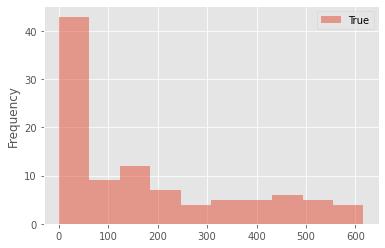

In [32]:
# check time frame in each AML cycle
alert_tx['tran_timestamp'] = pd.to_datetime(alert_tx['tran_timestamp'], format='%Y-%m-%d')
time_frame_AML = alert_tx.groupby(['alert_id', 'is_sar'])['tran_timestamp'].agg([max, min])
time_frame_AML['delta'] = time_frame_AML['max'] - time_frame_AML['min']
time_frame_AML['days'] = time_frame_AML['delta'].dt.days
time_frame_AML.groupby('is_sar')['days'].plot.hist(legend=True, alpha=0.5)

is_sar
True    AxesSubplot(0.125,0.125;0.775x0.755)
Name: delta_per, dtype: object

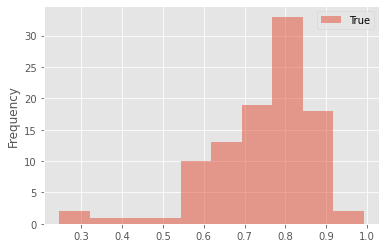

In [33]:
# check delta amount in each AML cycle
amount_aml = alert_tx.groupby(['alert_id', 'is_sar'])['base_amt'].agg([min, max])
amount_aml['delta'] = amount_aml['max'] - amount_aml['min']
amount_aml['delta_per'] = amount_aml['delta'] / amount_aml['max']
amount_aml.groupby('is_sar')['delta_per'].plot.hist(legend=True, alpha=0.5)
# %%

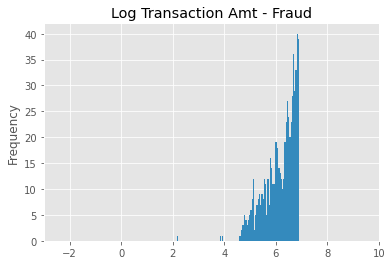

In [34]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

alert_tx.loc[alert_tx['is_sar'] == True] \
    ['base_amt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10)
         )

plt.show()

#### Observation of SAR based on alerts raised during each transaction
1. We can notice that the Highest number of alerts were raised during Jan 2017. All these alerts are cyclic in nature which are mostly associated with `TRANSFER - transaction type`.
2. We also notices that all these unique alerts are SAR alerts(TRUE).
3. We can see that the distribution of amount when SAR(TRUE) is between `200, 400, 600, 800 and 1000 dollars` with minimum transaction value(`$8.77`). This shows that these are true positive alerts

## Semi supervised machine learning
In this kernel, I have explained how to perform classification task using semi supervised learning approach. This approach makes use of autoencoders to learn the representation of the data then a simple linear classifier is trained to classify the dataset into respective classes.

One of the biggest challenge of this problem is that the target is highly imbalanced as only 0.34 % cases are AML transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how.
For our use-case let us take only about 1000 rows of non-AML transactions.

In [35]:
vc = trx['is_sar'].value_counts().to_frame().reset_index()
vc['percent'] = vc["is_sar"].apply(lambda x : round(100*float(x) / len(trx), 2))
vc = vc.rename(columns = {"index" : "Target", "is_sar" : "Count"})
vc

,Target,Count,percent
0,False,197234,99.66
1,True,671,0.34


In [37]:
# replacing values
model_data = original_trx_data.copy()
model_data['tx_type'].replace(['TRANSFER'],
                        [0], inplace=True)
model_data['tran_timestamp'] = pd.to_datetime(model_data['tran_timestamp'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

In [38]:
##converting date variable to datetime 
model_data['createdon']=pd.to_datetime(model_data['tran_timestamp'])

##year
model_data['year']=model_data['tran_timestamp'].dt.year

##month in numeric
model_data['month']=model_data['tran_timestamp'].dt.month

## Month Name
model_data['Month Name']=model_data['tran_timestamp'].dt.month_name()

## Name of the day
model_data['Day Name']=model_data['tran_timestamp'].dt.day_name()

## Hour if the day
model_data['Hours']= model_data['tran_timestamp'].dt.hour

## Feature to identify Weekday and Weekend
model_data['Day of week']=['Weekend' if i in (['Saturday','Sunday']) else 'Weekday' for i in model_data['Day Name'] ]

In [39]:
model_data.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id,createdon,year,month,Month Name,Day Name,Hours,Day of week
0,1,4376,170,0,885.30,2017-01-01,False,-1,2017-01-01,2017,1,January,Sunday,0,Weekend
1,2,4300,23,0,630.41,2017-01-01,False,-1,2017-01-01,2017,1,January,Sunday,0,Weekend
2,3,4433,12,0,393.14,2017-01-01,False,-1,2017-01-01,2017,1,January,Sunday,0,Weekend
3,4,2552,6503,0,659.74,2017-01-01,False,-1,2017-01-01,2017,1,January,Sunday,0,Weekend
4,5,2552,6503,0,442.44,2017-01-01,False,-1,2017-01-01,2017,1,January,Sunday,0,Weekend


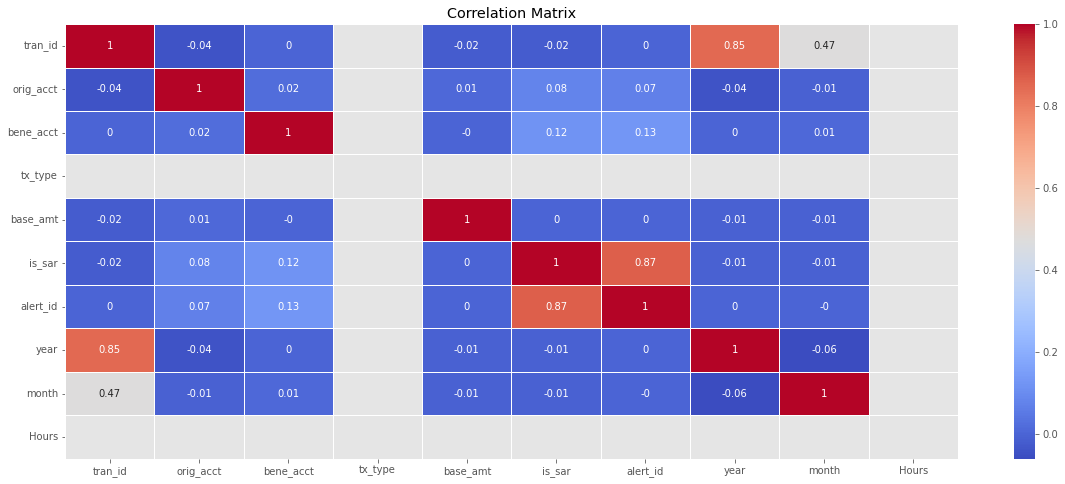

In [40]:
corr1 = model_data.corr()

plt.figure(figsize=(20,8))
fig = sns.heatmap(corr1.round(2), cmap='coolwarm', linewidths=.5, annot=True)
fig.set(title="Correlation Matrix");

As we can see high correlation between `year<->tran_id` , `day-name<->day-of-week` and `alert_id<->is_sar`. This is understandable since we can see from previous analysis that the sar alerts were high in `Jan 2021` which is were we had more transactions

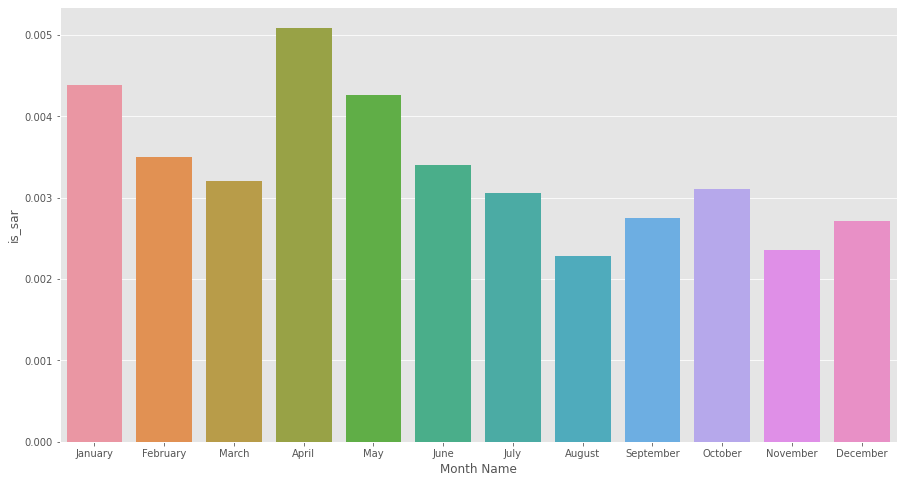

In [41]:
gb=model_data.groupby(['month','Month Name'])['is_sar'].mean().reset_index()
plt.figure(figsize=(15,8))
sns.barplot(x='Month Name',y='is_sar',data=gb);

In [42]:
# Create a dictionary using which we
# will remap the values
month = {'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October':10, 'November':11, 'December':12}
day = {'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
week = {'Weekday' : 0, 'Weekend' : 1}

# Remap the values of the dataframe
model_data.replace({"Month Name": month, "Day Name": day, "Day of week": week}, inplace=True)

In [43]:
model_data.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id,createdon,year,month,Month Name,Day Name,Hours,Day of week
0,1,4376,170,0,885.30,2017-01-01,False,-1,2017-01-01,2017,1,1,7,0,1
1,2,4300,23,0,630.41,2017-01-01,False,-1,2017-01-01,2017,1,1,7,0,1
2,3,4433,12,0,393.14,2017-01-01,False,-1,2017-01-01,2017,1,1,7,0,1
3,4,2552,6503,0,659.74,2017-01-01,False,-1,2017-01-01,2017,1,1,7,0,1
4,5,2552,6503,0,442.44,2017-01-01,False,-1,2017-01-01,2017,1,1,7,0,1


In [44]:
version_1 = model_data[['tran_id','orig_acct','bene_acct','tx_type','base_amt','is_sar','alert_id']]

In [45]:
#Using limited features  
version_1.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,is_sar,alert_id
0,1,4376,170,0,885.30,False,-1
1,2,4300,23,0,630.41,False,-1
2,3,4433,12,0,393.14,False,-1
3,4,2552,6503,0,659.74,False,-1
4,5,2552,6503,0,442.44,False,-1


One of the biggest challenge of this problem is that the target is highly imbalanced which are NON SAR transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how. For our use-case let's take only about 1000 rows of non-SAR transactions.

In [46]:
non_AML = version_1[version_1['is_sar'] == False].sample(1000)
aml = version_1[version_1['is_sar'] == True]

df = non_AML.append(aml).sample(frac=1).reset_index(drop=True)
X = df.drop(['is_sar'], axis = 1).values
Y = df["is_sar"].values

/tmp/ipykernel_1926/4274825679.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_AML.append(aml).sample(frac=1).reset_index(drop=True)


In [47]:
df.head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,is_sar,alert_id
0,104362,2547,22,0,729.92,False,-1
1,1002,6749,392,0,413.12,True,16
2,111729,13,4347,0,324.03,True,33
3,29072,85,25,0,991.87,False,-1
4,17618,11581,506,0,610.75,True,2


In [48]:
print(X.shape)
print(Y.shape)

(1671, 6)
(1671,)


#### Visualize AML and NonAML Transactions
Let's visualize the nature of fraud and non-fraud transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

Every dot in the following represents a transaction. Non AML transactions are represented as Green while AML transactions are represented as Red. The two axis are the components extracted by tsne.

In [50]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(X)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1671 samples in 0.002s...
[t-SNE] Computed neighbors for 1671 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1671
[t-SNE] Computed conditional probabilities for sample 1671 / 1671
[t-SNE] Mean sigma: 2469.907006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.439735
[t-SNE] KL divergence after 5000 iterations: 0.392114


In [51]:
tsne_scale_results.shape

(1671, 2)

In [52]:
tsne_df = pd.DataFrame(columns=['tsne1','tsne2', 'is_sar'], data = np.column_stack((tsne_scale_results, Y)))

In [53]:
# cast targets column to int
tsne_df.loc[:, 'is_sar'] = tsne_df.is_sar.astype(int)
tsne_df.head()

,tsne1,tsne2,is_sar
0,-55.982250,2.812806,0
1,67.407463,-8.028997,1
2,-47.837578,10.661321,1
3,34.339550,-37.474995,0
4,41.702248,-22.666340,1


In [54]:
sar_map = {0:'False',
            1: 'True'}
# map targets to actual clothes for plotting
tsne_df.loc[:, 'is_sar'] = tsne_df.is_sar.map(sar_map)

<AxesSubplot:>

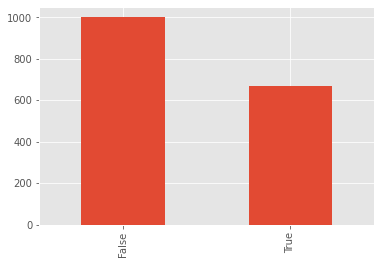

In [55]:
tsne_df.is_sar.value_counts().plot(kind='bar')

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


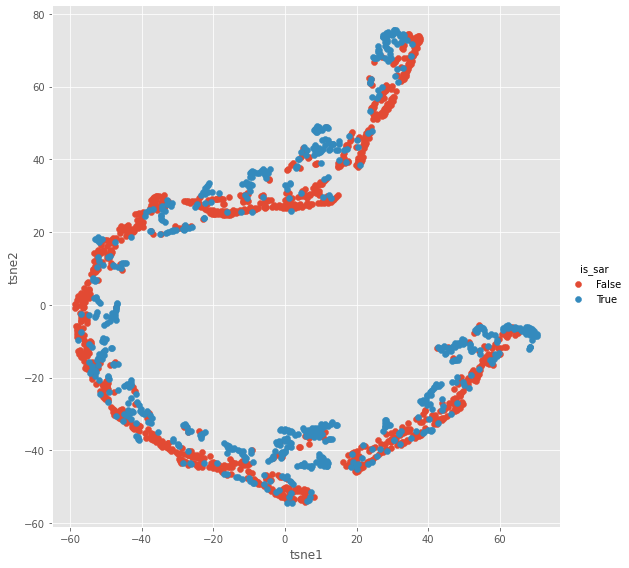

In [56]:
grid = sns.FacetGrid(tsne_df, hue="is_sar", size=8)
grid.map(plt.scatter, 'tsne1', 'tsne2').add_legend()

From the above graph we can observe that there are many non_SARtransactions which are very close to SAR transactions, thus are difficult to accurately classify from a model.

### AutoEncoders can help us over come this issue

What are Autoencoders? - Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.



We will create an autoencoder model in which we only show the model non-SAR cases. The model will try to learn the best representation of non-SAR cases. The same model will be used to generate the representations of SAR cases and we expect them to be different from non-SAR ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-SAR cases. We will use keras package.

In [57]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

2022-05-17 15:46:58.204052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 15:46:58.204088: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 15:46:58.204115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-05-17 15:46:58.204329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.

In [58]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Before training, let's perform min max scaling.

In [59]:
x = version_1.drop(["is_sar"], axis=1)
y = version_1["is_sar"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [60]:
x_norm.shape

(197234, 6)

In [61]:
x_fraud.shape

(671, 6)

The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will use only 2000 rows of non SAR cases to train the autoencoder. Additionally, We do not need to run this model for a large number of epochs.

Explanation: The choice of small samples from the original dataset is based on the intuition that one class characteristics (non SAR) will differ from that of the other (SAR). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automaticlly distinuish the other class.

In [62]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
7/7 [==============================] - 1s 31ms/step - loss: 0.0688 - val_loss: 0.0679
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0686 - val_loss: 0.0677
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.0684 - val_loss: 0.0675
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0682 - val_loss: 0.0674
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0680 - val_loss: 0.0672
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.0678 - val_loss: 0.0670
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0676 - val_loss: 0.0668
Epoch 8/20
7/7 [==============================] - 0s 7ms/step - loss: 0.0674 - val_loss: 0.0666
Epoch 9/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0672 - val_loss: 0.0664
Epoch 10/20
7/7 [==============================] - 0s 6ms/step - loss: 0.0670 - val_loss: 0.0662
Epoch 11/20
7/7 [====================

Obtain the Latent Representations
Now, the model is trained. We are intereseted in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

In [63]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes : non-SAR and SAR by predicting the raw inputs using the above model.

In [64]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

21/21 [==============================] - 0s 1ms/step


Now we will create a training dataset using the latent representations obtained and let's visualize the nature of SAR vs non-SAR cases.

In [66]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [67]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(rep_x)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3671 samples in 0.001s...
[t-SNE] Computed neighbors for 3671 samples in 0.514s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3671
[t-SNE] Computed conditional probabilities for sample 2000 / 3671
[t-SNE] Computed conditional probabilities for sample 3000 / 3671
[t-SNE] Computed conditional probabilities for sample 3671 / 3671
[t-SNE] Mean sigma: 0.013204
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.957668
[t-SNE] KL divergence after 5000 iterations: 0.521105


In [69]:
tsne_df_1 = pd.DataFrame(columns=['tsne1','tsne2', 'is_sar'], data = np.column_stack((tsne_scale_results, rep_y)))

In [70]:
sar_map = {0:'False',
            1: 'True'}
# map targets to actual clothes for plotting
tsne_df_1.loc[:, 'is_sar'] = tsne_df_1.is_sar.map(sar_map)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


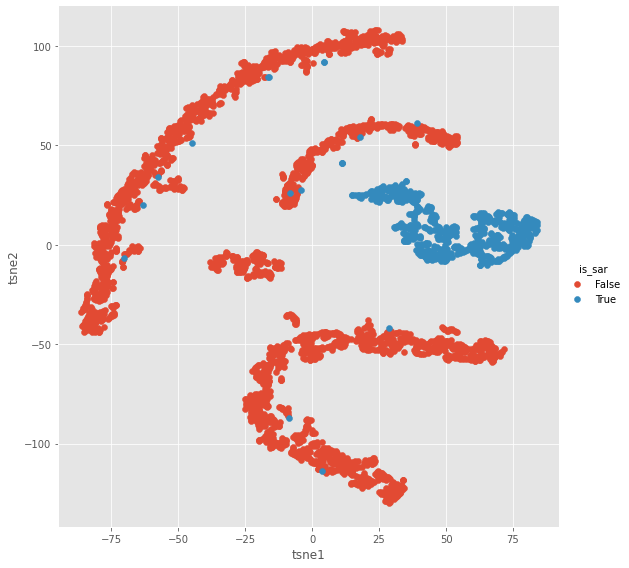

In [71]:
grid = sns.FacetGrid(tsne_df_1, hue="is_sar", size=8)
grid.map(plt.scatter, 'tsne1', 'tsne2').add_legend()

What a perfect graph, we can observe that now SAR and non-SAR transactions are pretty visibile and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict. Here is the before and after view of SAR and Non SAR transactions.

In [74]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

print ("")
print("Confusion matrix: ", confusion_matrix(val_y,pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       749
         1.0       1.00      0.89      0.94       169

    accuracy                           0.98       918
   macro avg       0.99      0.95      0.97       918
weighted avg       0.98      0.98      0.98       918


Accuracy Score:  0.9803921568627451

Confusion matrix:  [[749   0]
 [ 18 151]]


In [76]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(val_y,pred_y)

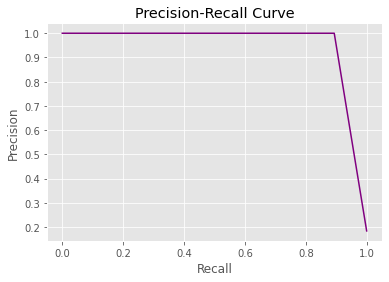

In [77]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

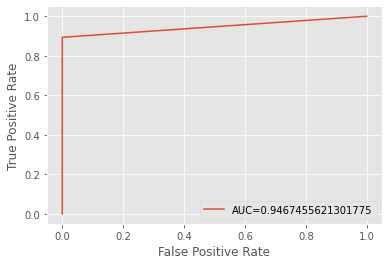

In [79]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(val_y,pred_y)
auc = metrics.roc_auc_score(val_y,pred_y)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Final conclusion
1. The AUC for this logistic regression model turns out to be 0.94. Since this is close to 1 our model is able to properly classify NON SAR and SAR transaction
2. We also used Precision-Recall score to judge the model's performance and it turned out to be excellent. 

Based on our initial assumption and feature engineering we can concludde that Auto encoder can be one of the suitable approach to solve this challenge